In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.5.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/code-mixed/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/code-mixed/classification')

In [8]:
df = pd.read_csv(path/'HOT_Dataset_modified.csv', header=None)[::2]
df.head()

0                                                  1    2    3    4    5   \
0  0.0  @saud5683 @Mutayyab420 @shivang598 @Ranask35 @...  NaN  NaN  NaN  NaN   
2  2.0  Banti hai empowered woman, feminism pe gyan pe...  NaN  NaN  NaN  NaN   
4  2.0  RT @kim_jong_korea: @updatingwait @Acutereply ...  NaN  NaN  NaN  NaN   
6  2.0  @InviSibleSold @mabkhan86 @dridadahn Punjab in...  NaN  NaN  NaN  NaN   
8  2.0  RT @MrMonsterSaid: Agar koi bole ki ja ke chil...  NaN  NaN  NaN  NaN   

    6    7    8    9    10   11   12   13   14   15   16   17   18  
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [ ]:
df[]

In [5]:
df_train = pd.read_csv(path/'bbc-hindiv01'/'hindi-train.csv', sep="\t", encoding='utf-8', header=None)
df_train.head()

0                                                  1
0     india  मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1  pakistan  नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2      news  इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3     india  प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ...
4     india  ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...

In [6]:
df_test = pd.read_csv(path/'bbc-hindiv01'/'hindi-test.csv', sep="\t", encoding='utf-8', header=None)
df_test.head()

0                                                  1
0          india  बुधवार को राज्य सभा में विपक्ष के सवालों के जव...
1          india  लखनऊ स्थित पत्रकार समीरात्मज मिश्र को बुलंदशहर...
2          india  लगभग 1300 हेक्टेयर ज़मीन का अधिग्रहण किया जा च...
3  international  हालांकि उनके अंगरक्षकों को बमों को जाम करने वा...
4          india  आयोग का कहना है कि इस तरह के परीक्षण से महिलाओ...

In [7]:
all_classes = df_train[0].unique()

In [10]:
for c in all_classes:
    print(c, (df_train[0] == c).sum())

india 1390
pakistan 43
news 230
international 904
entertainment 285
sport 258
science 194
china 14
learningenglish 5
social 18
southasia 42
business 54
institutional 19
multimedia 12


In [11]:
df_train.shape, df_test.shape

((3468, 2), (867, 2))

In [12]:
df_train[df_train[1].isnull()]

0    1
718  india  NaN

In [13]:
df_train = df_train.dropna()

In [14]:
df_test[df_test[1].isnull()]

0    1
265  sport  NaN

In [15]:
df_test = df_test.dropna()

In [16]:
label_cols = [0]

In [17]:
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str('/home/gaurav/Downloads/LanguageModel/hindi_lm.model'))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [18]:
sp = spm.SentencePieceProcessor()
sp.Load('/home/gaurav/Downloads/LanguageModel/hindi_lm.model')
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [19]:
itos

['<unk>',
 '<s>',
 '</s>',
 '▁के',
 '।',
 '▁में',
 '▁है',
 ',',
 '▁',
 '▁की',
 '▁और',
 '▁से',
 '▁का',
 '▁को',
 '▁हैं',
 '▁एक',
 '▁पर',
 '.',
 '-',
 '▁भी',
 '▁ने',
 '▁किया',
 '▁·',
 '▁यह',
 '▁था',
 '▁लिए',
 '▁इस',
 '▁गया',
 'ों',
 '▁कि',
 'ी',
 '▁जाता',
 '▁जो',
 '▁रूप',
 '▁ही',
 '▁q',
 '▁�',
 '▁कर',
 '▁हो',
 '▁करने',
 '▁तथा',
 '▁नहीं',
 '▁द्वारा',
 '▁या',
 'X',
 '▁थे',
 '▁साथ',
 '▁•',
 'ा',
 '▁भारत',
 '▁होता',
 '▁बाद',
 '▁तक',
 ':',
 '▁"',
 '▁दिया',
 '▁अपने',
 '▁थी',
 '▁हुआ',
 'न',
 '▁कुछ',
 '"',
 '▁जिला',
 '�',
 '▁एवं',
 '▁इसके',
 '▁वे',
 '▁वह',
 '▁|',
 "'",
 '▁नाम',
 '▁जा',
 '▁राज्य',
 '▁समय',
 '▁होती',
 '▁करते',
 '▁हुए',
 '▁तो',
 '▁कई',
 "▁'",
 '▁अन्य',
 '▁अधिक',
 '▁क्षेत्र',
 '▁कारण',
 'े',
 '▁सबसे',
 '▁प्रकार',
 '▁होने',
 'क',
 '▁सकता',
 '▁स्थित',
 'र',
 '▁उनके',
 '▁भारतीय',
 '▁उन्होंने',
 '▁किसी',
 '▁वर्ष',
 '▁जाती',
 '▁वाले',
 '▁बहुत',
 '▁होते',
 '▁करता',
 'ता',
 '▁दो',
 '▁व',
 'ं',
 '▁अपनी',
 '▁कहा',
 '▁पूर्व',
 '▁पहले',
 '▁गए',
 '▁इन',
 '▁हुई',
 '▁जैसे',
 '▁जब',
 '▁ये',
 '▁कम',

In [20]:
# 30,000 is the vocab size that we chose in sentencepiece
hindi_vocab = Vocab(itos)

In [21]:
tokenizer = Tokenizer(tok_func=HindiTokenizer, lang='hi')

In [22]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [23]:
data_lm = TextDataBunch.from_df(path=path, train_df=df_train, valid_df=df_test, tokenizer=tokenizer, vocab=hindi_vocab)

In [24]:
data_lm.save()

In [25]:
bs=32

In [26]:
data_lm = TextLMDataBunch.load(path, 'tmp', bs=bs)

In [27]:
data_lm.show_batch()

In [28]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [29]:
# Loading the pretrained language model on hindi wikipedia
learn.load('/home/gaurav/Downloads/LanguageModel/HindiDataset/models/third_hi_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (3467 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/Downloads/HindiClassificationModel-2
x: LMTextList (3467 items)
[Text ▁x x bo s ▁मेट्रो ▁की ▁इस ▁लाइन ▁के ▁चलने ▁से ▁दक्षिणी ▁दिल्ली ▁से ▁नोएडा ▁जाने ▁का ▁समय ▁काफी ▁कम ▁हो ▁जाएगा ▁और ▁यात्रियों ▁को ▁राजीव ▁चौक ▁या ▁मंडी ▁हाउस ▁से ▁होकर ▁नहीं ▁जाना ▁पड़ेगा . लेकिन , ▁यह ▁म जेंट ा ▁लाइन ▁इसलिए ▁भी ▁महत्वपूर्ण ▁है ▁क्योंकि ▁इस ▁पर ▁ड्राइव लै स ▁यानी ▁बिना ▁ड्राइवर ▁वाली ▁मेट्रो ▁चलाने ▁की ▁योजना ▁है . ▁ऐसा ▁भारत ▁में ▁पहली ▁बार ▁होगा ▁जब ▁कोई ▁मेट्रो ▁बिना ▁ड्राइवर ▁के ▁चलाई ▁जाएगी . ▁मेट्रो ▁के ▁तीसरे ▁फेज ▁में ▁भारत ▁में ▁पहली ▁बार ▁ड्राइवर लेस ▁तकनीक ▁आएगी ▁लेकिन ▁दुनिया ▁भर ▁में ▁कई ▁देशों ▁में ▁ड्राइवर लेस ▁मेट्रो ▁पहले ▁से ▁ही ▁चलती ▁हैं . ▁इन ▁देशों ▁में ▁ड्राइवर लेस ▁मेट्रो ▁सफल ▁भी ▁रही ▁हैं . ▁दक्षिण ▁कोरिया ▁की ▁राजधानी ▁सोल ▁में ▁ड्राइव लेस ▁ट्रेन ▁कामयाबी ▁से ▁चल ▁रही ▁है . ▁ये ▁मेट्रो ▁ज़मीन ▁के ▁नीचे ▁चलती ▁है ▁इ

In [30]:
# Fine tuning the prtrained LM on current dataset

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


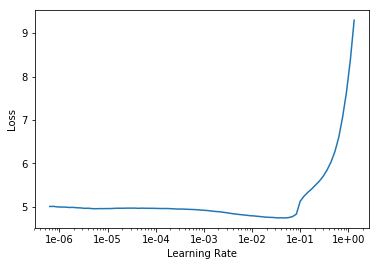

In [58]:
learn.recorder.plot()

In [59]:
learn.freeze()

In [60]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [61]:
learn.save('fit_head', with_opt=True)

In [62]:
learn.load('fit_head', with_opt=True);

In [63]:
learn.unfreeze()

In [64]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

In [65]:
learn.save('fine_tuned', with_opt=True)

In [31]:
learn.load('fine_tuned', with_opt=True);

In [69]:
learn.predict('▁इस ▁लाइन ▁के ▁चलने ▁से ▁दक्षिणी ',n_words=10)

'▁इस ▁लाइन ▁के ▁चलने ▁से ▁दक्षिणी  ▁कोरिया ▁ईस ▁- धे पा ▁ ▁लक्षद्वीप s ▁ g'

In [70]:
learn.save_encoder('fine_tuned_enc')

In [32]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=df_train, valid_df=df_test, tokenizer=tokenizer, vocab=hindi_vocab)

In [72]:
data_clas.show_batch()

In [73]:
data_clas.sanity_check()

In [33]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [34]:
learn.load_encoder('fine_tuned_enc')

In [76]:
learn.freeze()

In [77]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


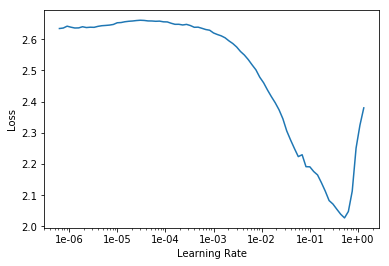

In [78]:
learn.recorder.plot()

In [35]:
learn.loss_func.func

CrossEntropyLoss()

In [36]:
kappa = KappaScore()

In [37]:
learn.metrics = [kappa, accuracy]

In [83]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

In [84]:
learn.save('first-full')

In [43]:
learn.load('first-full');

In [44]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [45]:
learn.save('second-full')

In [46]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [47]:
learn.save('final')